# Understanding the Problem Statement

We’ll dive into the implementation part of this article soon, but first it’s important to establish what we’re aiming to solve. Broadly, stock market analysis is divided into two parts – Fundamental Analysis and Technical Analysis.

1. Fundamental Analysis involves analyzing the company’s future profitability on the basis of its current business environment and financial performance.
2. Technical Analysis, on the other hand, includes reading the charts and using statistical figures to identify the trends in the stock market.

As you might have guessed, our focus will be on the technical analysis part. We’ll be using the dataset of Microsoft stock prices from April 2015 to April 2021 to build a model capable of estimating the stock prices. Time to dive in!

In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv


In [15]:
df = pd.read_csv('/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv')
df.head(8)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
5,4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861
6,4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002
7,4/13/2015 16:00:00,41.40,42.06,41.39,41.76,30276692


**Major Points of Understanding** 
 
There are multiple variables in the dataset – Date, Open, High, Low, Close and volume.

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.

High and Low represent the maximum and minimum price of the share for the day.

Volume is the number of shares bought or sold in the day 

Another important thing to note is that the market is closed on weekends and public holidays.Notice the above table again, some date values are missing – 4/3/2015, 4/4/2015 and 4/5/2015. Of these dates, 3rd April 2015 was a public holiday due to the occasion of Good Friday, while 4th and 5th April were weekends

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data

Text(0.5, 1.0, 'Stock Price of Microsoft over the Years')

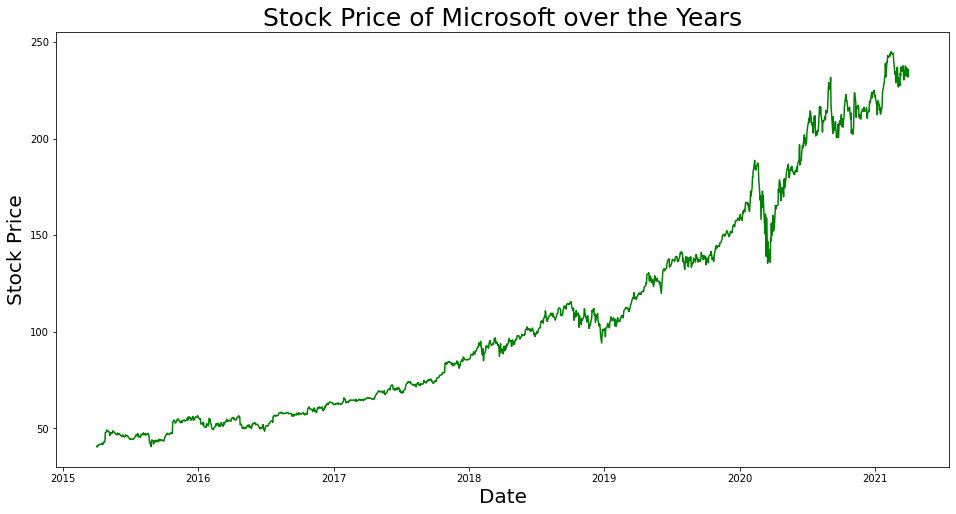

In [16]:
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y %H:%M:%S')
df.index = df['Date']
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft over the Years',size=25)

In the upcoming sections, we will explore these variables and use different techniques to predict the daily closing price of the stock.

## Moving Average

#### Introduction

‘Average’ is easily one of the most common things we use in our day-to-day lives. For instance, calculating the average marks to determine overall performance, or finding the average temperature of the past few days to get an idea about today’s temperature – these all are routine tasks we do on a regular basis. So this is a good starting point to use on our dataset for making predictions.

The predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the moving average technique which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set. Here is a simple figure that will help you understand this with more clarity.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/stock8.png)

We will implement this technique on our dataset. The first step is to create a dataframe that contains only the Date and Close price columns, then split it into train and validation sets to verify our predictions.

 

In [17]:
def moving_avg_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    preds = []
    for i in range(0,valid_set.shape[0]):
        a = train_set['Close'][len(train_set)-valid_set.shape[0]+i:].sum() + sum(preds)
        b = a/(valid_set.shape[0])
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Moving Averages',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 76.62376749929759
-----------------------------------------------------------
-----------------------------------------------------------


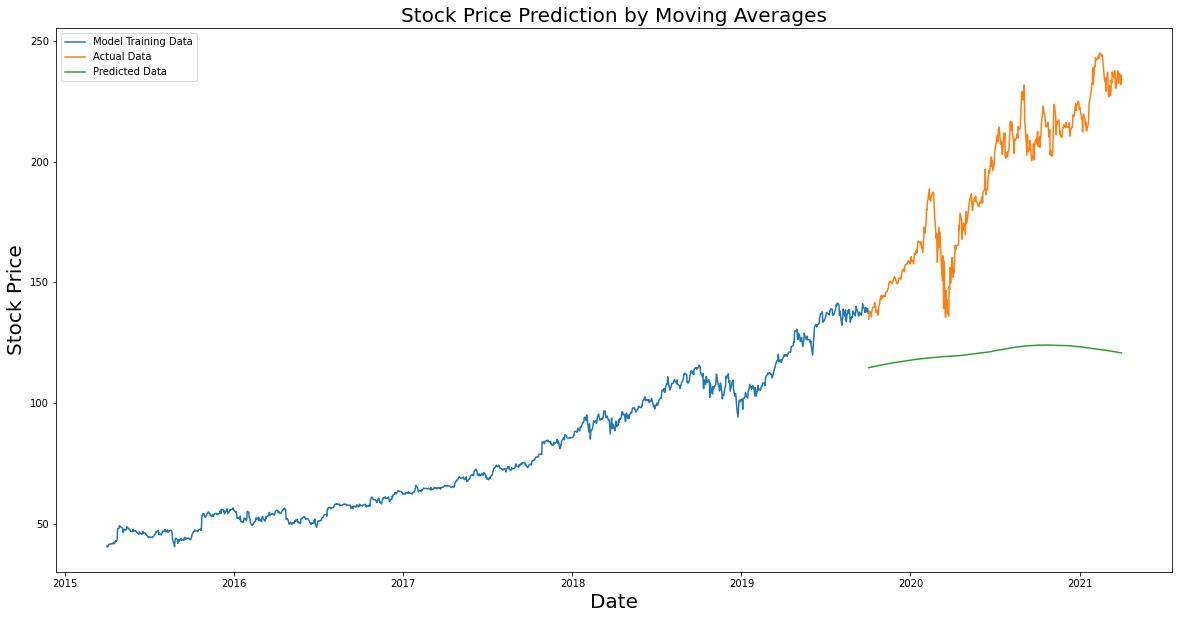

In [18]:
moving_avg_prediction(df)

**Observation-** The RMSE value is close to 76.62 but the results are not very promising (as you can gather from the plot). The predicted values are of the same range as the observed values in the train set (there is an increasing trend initially and then a slow decrease).

In the next section, we will look at two commonly used machine learning techniques – Linear Regression and kNN, and see how they perform on our stock market data.

# Linear Regression

### Introduction

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.

The equation for linear regression can be written as:

Here, x1, x2,….xn represent the independent variables while the coefficients θ1, θ2, …. θn  represent the weights. You can refer to the following article to study linear regression in more detail:

A comprehensive beginners guide for Linear, Ridge and Lasso Regression.
For our problem statement, we do not have a set of independent variables. We have only the dates instead. Let us use the date column to extract features like – day, month, year,  mon/fri etc. and then fit a linear regression model.

## Implementation
We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [49]:
def linear_regression_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------')
    print('-----------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    #implement linear regression
    model = LinearRegression()
    model.fit(np.array(x_train).reshape(-1,1),y_train)
    preds = model.predict(np.array(x_valid).reshape(-1,1))
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Linear Regression',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------
-----------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 58.36609230803357
-----------------------------------------------------------
-----------------------------------------------------------


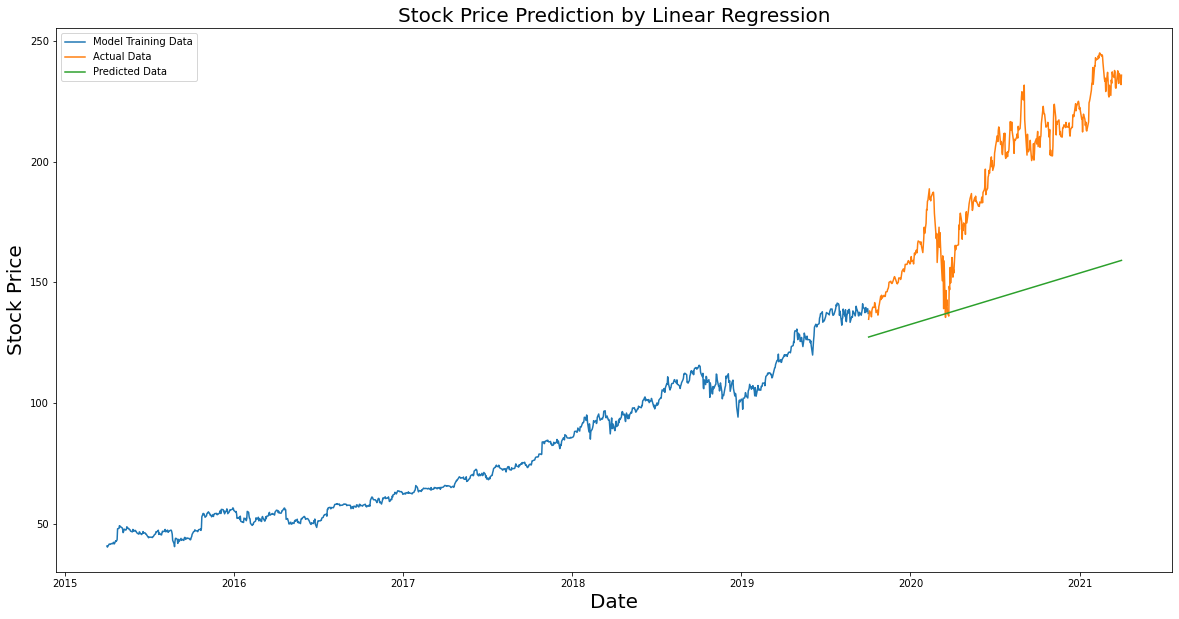

In [50]:
linear_regression_prediction(df)

# K-Nearest Neighbours

### Introduction
Another interesting ML algorithm that one can use here is kNN (k nearest neighbours). Based on the independent variables, kNN finds the similarity between new data points and old data points. Let me explain this with a simple example.

Consider the height and age for 11 people. On the basis of given features (‘Age’ and ‘Height’), the table can be represented in a graphical format as shown below:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/stock18.png)


In [51]:
def k_nearest_neighbours_predict(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------')
    print('-------------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by K-Nearest Neighbors',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------
-------------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 112.9467566922719
-----------------------------------------------------------
-----------------------------------------------------------


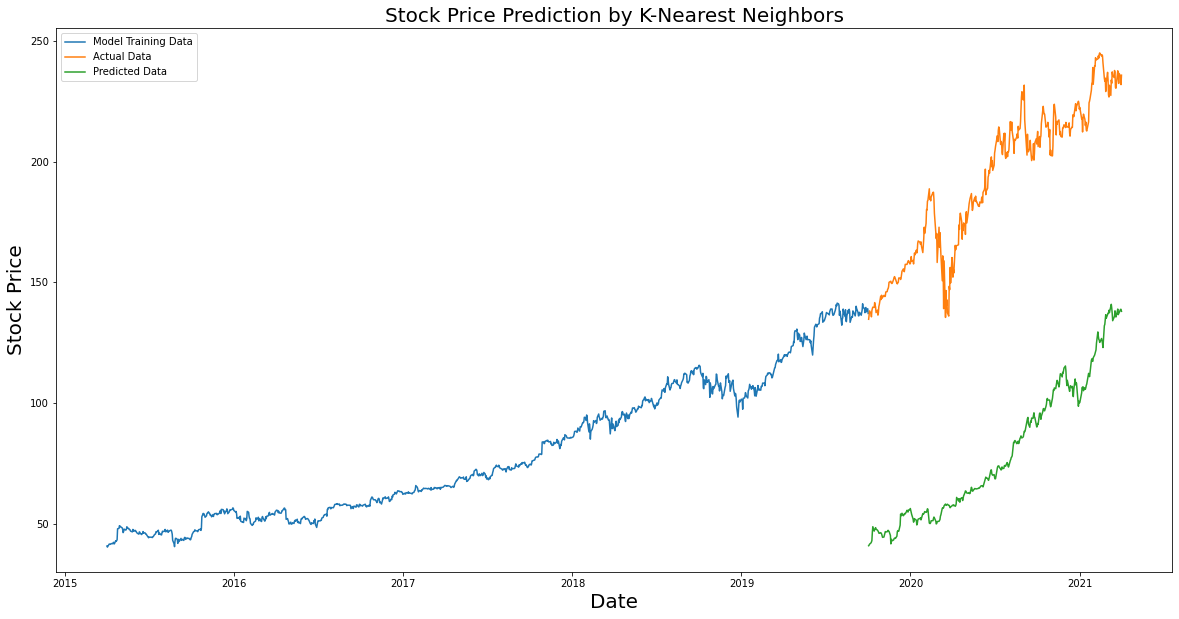

In [52]:
k_nearest_neighbours_predict(df)

**Observation**- The RMSE value is almost similar to the linear regression model and the plot shows the same pattern. Like linear regression, kNN also identified a drop in January 2018 since that has been the pattern for the past years. We can safely say that regression algorithms have not performed well on this dataset.

Let’s go ahead and look at some time series forecasting techniques to find out how they perform when faced with this stock prices prediction challenge.

# Auto ARIMA

## Introduction
ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

1. p (past values used for forecasting the next value)
2. q (past forecast errors used to predict the future values)
3. d (order of differencing)

Parameter tuning for ARIMA consumes a lot of time. So we will use auto ARIMA which automatically selects the best combination of (p,q,d) that provides the least error. To read more about how auto ARIMA works, refer to this article:

In [53]:
def auto_arima_prediction(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_set=data[:ceil(shape*0.75)]
    valid_set=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = train_set['Close']
    validation = valid_set['Close']
    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set['Close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (1134, 6)
Shape of Validation Set (377, 6)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4440.431, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4126.393, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4427.420, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3999.903, Time=1.01 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4015.175, Time=0.90 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3983.513, Time=1.40 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4107.542, Time=0.73 se

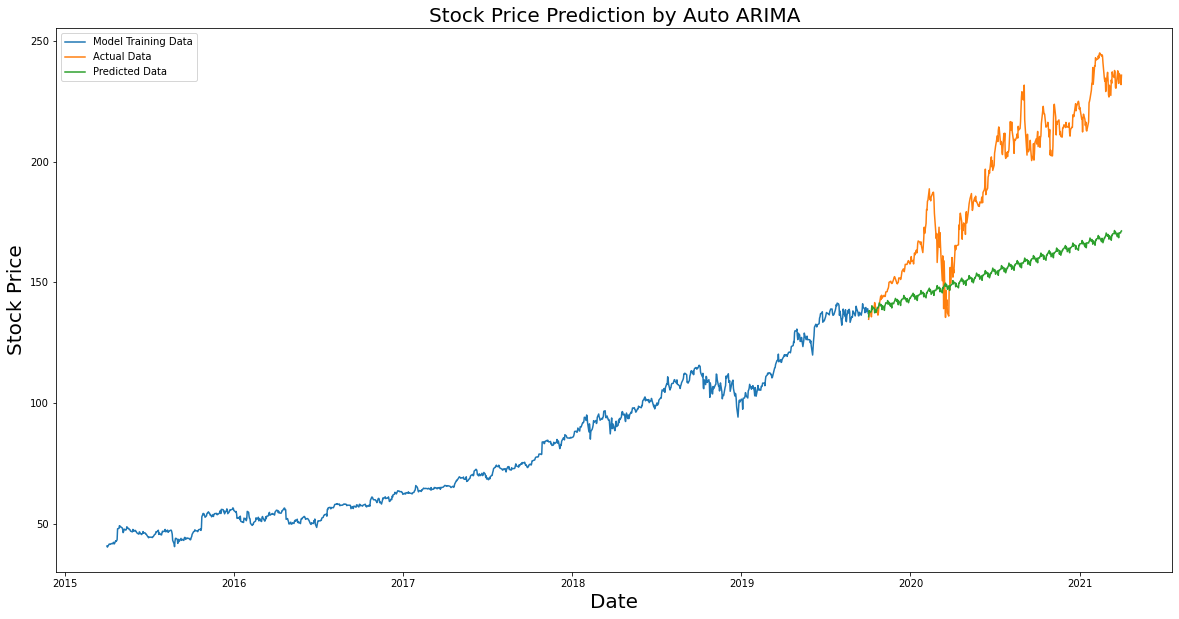

In [54]:
auto_arima_prediction(df)

**Observation** As we saw earlier, an auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. Although the predictions using this technique are far better than that of the previously implemented machine learning models, these predictions are still not close to the real values.

As its evident from the plot, the model has captured a trend in the series, but does not focus on the seasonal part. In the next section, we will implement a time series model that takes both trend and seasonality of a series into account.

# Prophet
### Introduction
There are a number of time series techniques that can be implemented on the stock prediction dataset, but most of these techniques require a lot of data preprocessing before fitting the model. Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

Prophet tries to capture the seasonality in the past data and works well when the dataset is large. Here is an interesting article that explains Prophet in a simple and intuitive manner:

In [57]:
def fb_prophet_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.reset_index(inplace=True)
    df_new['Date'] = pd.to_datetime(df_new.Date,format='%Y-%m-%d')
    df_new.index = df_new['Date']
    df_new.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY FB PROPHET-----------')
    print('-------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    model = Prophet()
    model.fit(train_set)
    close_prices = model.make_future_dataframe(periods=len(valid_set))
    forecast = model.predict(close_prices)
    forecast_valid = forecast['yhat'][ceil(shape*0.75):]
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['y'])-np.array(forecast_valid)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    valid['Predictions'] = forecast_valid.values
    plt.plot(train_set['y'])
    plt.plot(valid_set[['y', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by FB Prophet',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-------------------------------------------------------
-----------STOCK PRICE PREDICTION BY FB PROPHET-----------
-------------------------------------------------------
Shape of Training Set (1134, 2)
Shape of Validation Set (377, 2)
RMSE value on validation set: 69.19405269585594
-----------------------------------------------------------
-----------------------------------------------------------


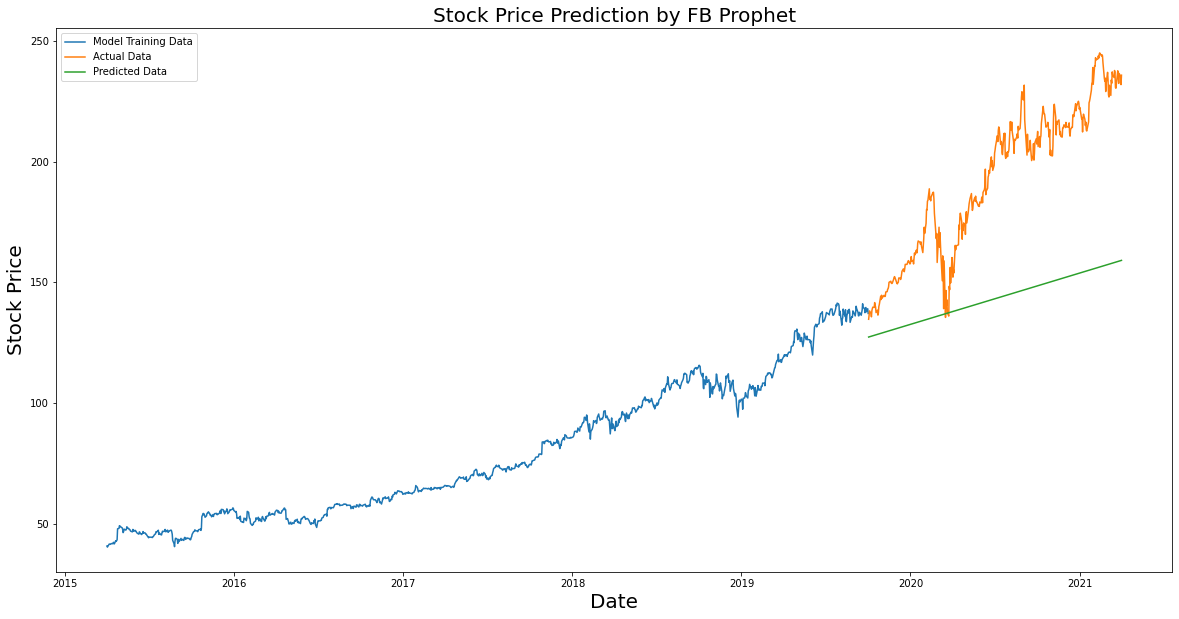

In [58]:
fb_prophet_prediction(df)

**Observation**- Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time series datasets, but fails to live up to it’s reputation in this case.

As it turns out, stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall. Hence forecasting techniques like ARIMA, SARIMA and Prophet would not show good results for this particular problem.

Let us go ahead and try another advanced technique – **Long Short Term Memory (LSTM)**.

# Long Short Term Memory (LSTM)

### Introduction
LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

The input gate: The input gate adds information to the cell state
The forget gate: It removes the information that is no longer required by the model
The output gate: Output Gate at LSTM selects the information to be shown as output
For a more detailed understanding of LSTM and its architecture, you can go through the below article:

#### Introduction to Long Short Term Memory
For now, let us implement LSTM as a black box and check it’s performance on our particular data.

 

In [59]:
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.75)]
    valid=df_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
1094/1094 - 16s - loss: 4.6585e-04
RMSE value on validation set: Close    6.373879
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


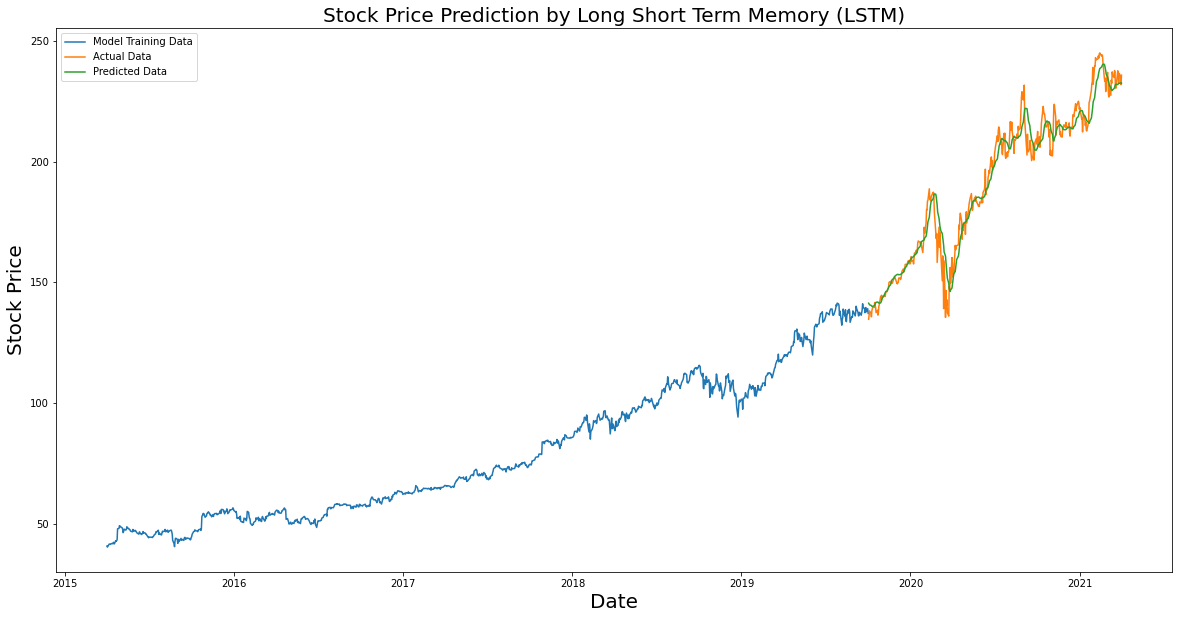

In [61]:
lstm_prediction(df)

**Observation** Wow! The LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs. But are the predictions from LSTM enough to identify whether the stock price will increase or decrease? Certainly not!

As I mentioned at the start of the article, stock price is affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.

 

# Conclusion
Time series forecasting is a very intriguing field to work with, as I have realized during my time writing these articles. There is a perception in the community that it’s a complex field, and while there is a grain of truth in there, it’s not so difficult once you get the hang of the basic techniques.

I am interested in finding out how LSTM works on a different kind of time series problem and encourage you to try it out on your own as well. If you have any questions, feel free to connect with me in the comments section below.